In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [2]:
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn import metrics
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [3]:
os.environ["CUDA_VISIBLE_DEVICE"]=''

In [4]:
train = pd.read_csv('C:\\Users\\.csv',usecols=[])
test = pd.read_csv('C:\\Users\\.csv',usecols=[])

In [5]:
print(train.shape)
print(test.shape)

(463, 7)
(459, 7)


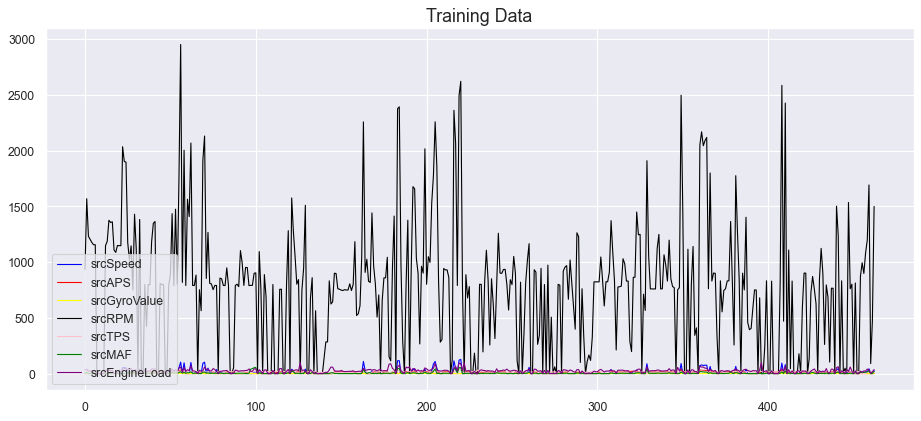

In [6]:
fig, ax = plt.subplots(figsize=(14,6),dpi=80)
#생략
plt.legend(loc='lower left')
ax.set_title('Training Data',fontsize=16)
plt.show()

In [7]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [8]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (463, 1, 7)
Test data shape: (459, 1, 7)


In [9]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(24, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(10, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(10, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(24, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [10]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 24)             3072      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1400      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 10)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 10)             840       
                                                                 
 lstm_3 (LSTM)               (None, 1, 24)             3360      
                                                             

In [11]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history


Epoch 1/100
44/44 [==============================] - 8s 27ms/step - loss: 0.2705 - val_loss: 0.2295
Epoch 2/100
44/44 [==============================] - 0s 4ms/step - loss: 0.2424 - val_loss: 0.2045
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.1817 - val_loss: 0.1438
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 0.1188 - val_loss: 0.1170
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 0.1047 - val_loss: 0.1137
Epoch 6/100
44/44 [==============================] - 0s 4ms/step - loss: 0.1026 - val_loss: 0.1127
Epoch 7/100
44/44 [==============================] - 0s 5ms/step - loss: 0.1013 - val_loss: 0.1115
Epoch 8/100
44/44 [==============================] - 0s 5ms/step - loss: 0.1001 - val_loss: 0.1109
Epoch 9/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0988 - val_loss: 0.1084
Epoch 10/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0975 - val_loss: 0.1078
Epoch 11

44/44 [==============================] - 0s 4ms/step - loss: 0.0656 - val_loss: 0.0714
Epoch 84/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0660 - val_loss: 0.0713
Epoch 85/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0655 - val_loss: 0.0713
Epoch 86/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0655 - val_loss: 0.0715
Epoch 87/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0652 - val_loss: 0.0718
Epoch 88/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0652 - val_loss: 0.0715
Epoch 89/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0652 - val_loss: 0.0716
Epoch 90/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0650 - val_loss: 0.0718
Epoch 91/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0650 - val_loss: 0.0723
Epoch 92/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0646 - val_loss: 0.0727
Epoch 93/100


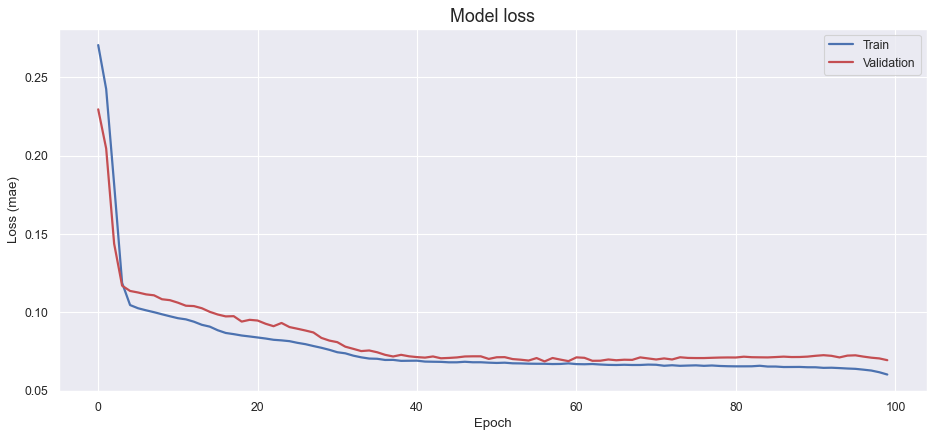

In [12]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [13]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

15/15 [==============================] - 1s 2ms/step


C:\Users\qhstj\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.1)

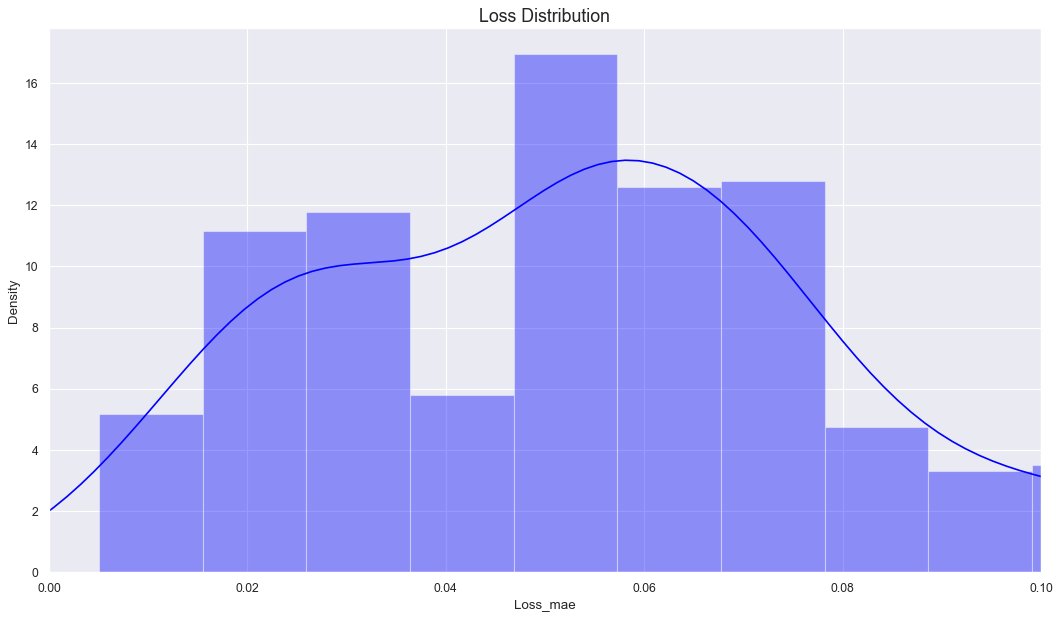

In [14]:
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.1])

In [15]:
print('anomaly threshold={}'.format(np.percentile(scored,100)))
threshold = np.percentile(scored,100)

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > (scored['Loss_mae'].mean())*2
scored#[scored['Anomaly']==True]

anomaly threshold=0.21408031674265418
15/15 [==============================] - 0s 2ms/step


,Loss_mae,Threshold,Anomaly
0,0.281704,0.21408,True
1,0.180653,0.21408,True
2,0.184585,0.21408,True
3,0.065285,0.21408,False
4,0.155373,0.21408,True
...,...,...,...
454,0.087708,0.21408,False
455,0.045076,0.21408,False
456,0.044574,0.21408,False
457,0.038154,0.21408,False


In [16]:
scored[scored['Anomaly']==True]

,Loss_mae,Threshold,Anomaly
0,0.281704,0.21408,True
1,0.180653,0.21408,True
2,0.184585,0.21408,True
4,0.155373,0.21408,True
5,0.172883,0.21408,True
6,0.149100,0.21408,True
7,0.309923,0.21408,True
8,0.305312,0.21408,True
14,0.170336,0.21408,True
23,0.280435,0.21408,True


Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

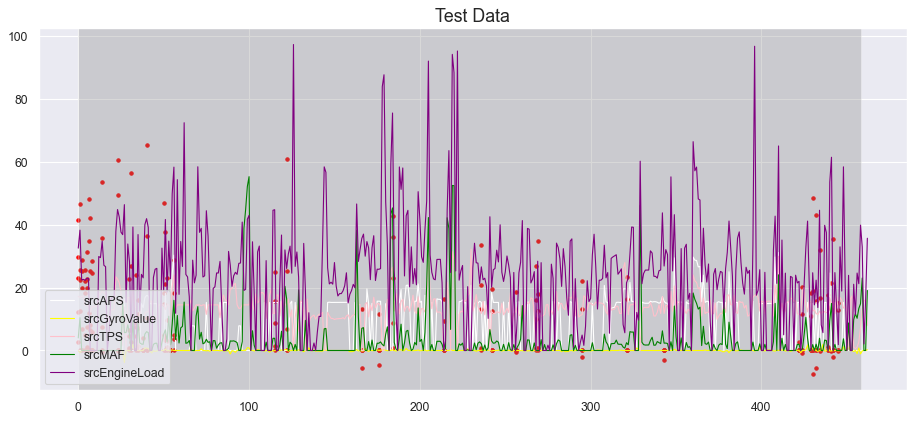

In [17]:
# plot bearing failure time plot
#scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

test_ = pd.DataFrame(test,columns=['srcSpeed','srcAPS','srcGyroValue','srcRPM','srcTPS','srcMAF','srcEngineLoad'])
fig, ax = plt.subplots(figsize=(14,6),dpi=80)
#생략
plt.legend(loc='lower left')
ax.set_title('Test Data',fontsize=16)
plt.axvspan(min(test_.index), max(test_.index),facecolor='gray',alpha=0.3)
plt.show()


This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [18]:
# save all model information, including weights, in h5 format
model.save("C:\\Users\Anomaly_Detection_paper_review.h5")
print("Model saved")

Model saved
